<a href="https://colab.research.google.com/github/Bhuvanachandhiran/bank-churn-logistic-regression/blob/main/Bank_Churn_Prediction_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn joblib

In [2]:
# Upload kaggle.json (run this cell, then click "Choose Files" to upload)
from google.colab import files
files.upload()  # Select your kaggle.json file

# Set up Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset (Bank Churn Competition)
!kaggle competitions download -c playground-series-s4e1
!unzip playground-series-s4e1.zip

# Now the files (train.csv, test.csv) are in your Colab session!

Saving kaggle.json to kaggle.json
  0% 0.00/6.81M [00:00<?, ?B/s]
100% 6.81M/6.81M [00:00<00:00, 896MB/s]
Archive:  playground-series-s4e1.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import joblib

In [4]:
# Load the training data (from the unzipped files)
train = pd.read_csv('train.csv')

# Display basic info
print("Dataset Shape:", train.shape)
print(train.head())
print(train.info())
print(train.describe())

Dataset Shape: (165034, 14)
   id  CustomerId         Surname  CreditScore Geography Gender   Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male  33.0       3   
1   1    15749177   Okwudiliolisa          627    France   Male  33.0       1   
2   2    15694510           Hsueh          678    France   Male  40.0      10   
3   3    15741417             Kao          581    France   Male  34.0       2   
4   4    15766172       Chiemenam          716     Spain   Male  33.0       5   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00              2        1.0             0.0        181449.97   
1       0.00              2        1.0             1.0         49503.50   
2       0.00              2        1.0             0.0        184866.69   
3  148882.54              1        1.0             1.0         84560.88   
4       0.00              2        1.0             1.0         15068.83   

   Exited  
0       0  
1       0 

Churn Distribution:
 Exited
0    0.788401
1    0.211599
Name: proportion, dtype: float64


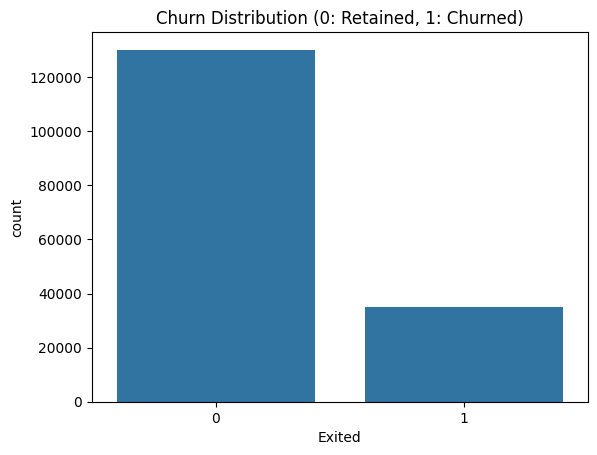

In [5]:
# Target distribution
print("Churn Distribution:\n", train['Exited'].value_counts(normalize=True))

# Plot
sns.countplot(x='Exited', data=train)
plt.title('Churn Distribution (0: Retained, 1: Churned)')
plt.show()

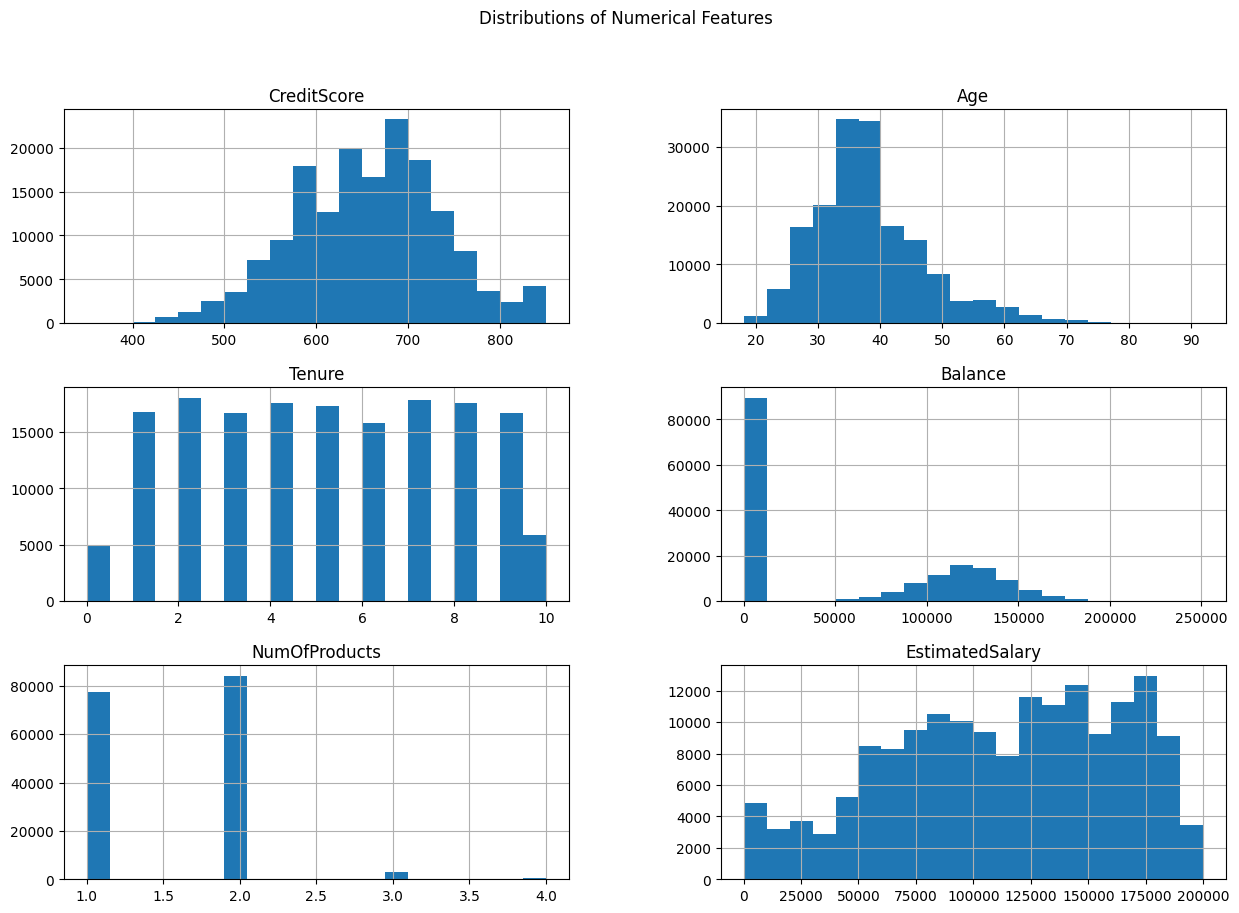

In [6]:
# Histograms for numerical features
num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
train[num_cols].hist(bins=20, figsize=(15, 10))
plt.suptitle('Distributions of Numerical Features')
plt.show()

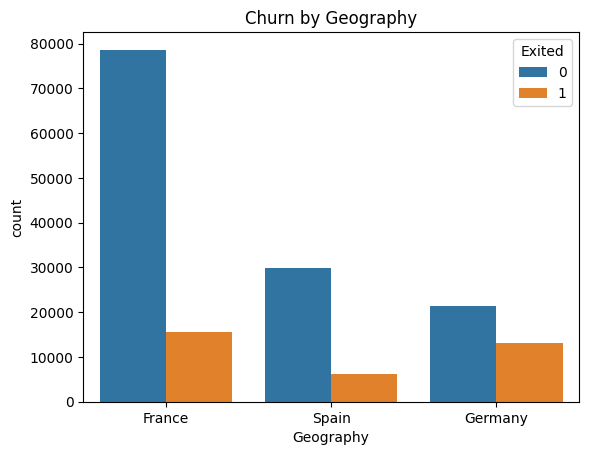

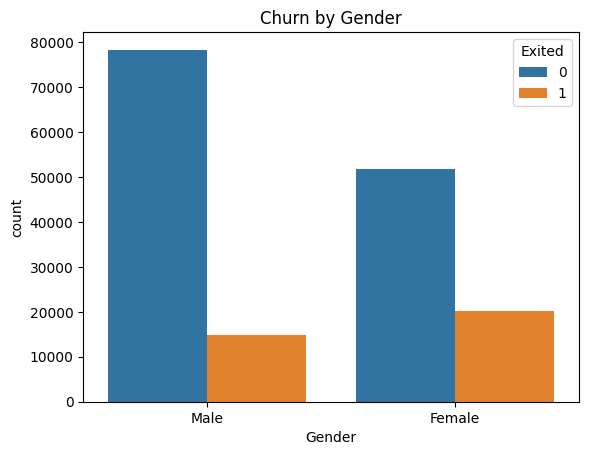

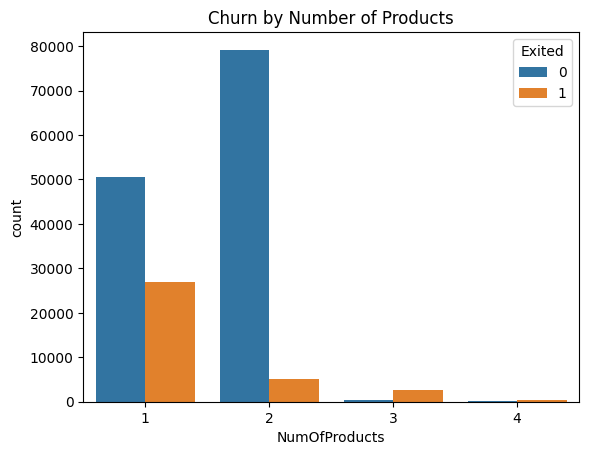

In [7]:
# Churn by Geography
sns.countplot(x='Geography', hue='Exited', data=train)
plt.title('Churn by Geography')
plt.show()

# Churn by Gender
sns.countplot(x='Gender', hue='Exited', data=train)
plt.title('Churn by Gender')
plt.show()

# Churn by Number of Products
sns.countplot(x='NumOfProducts', hue='Exited', data=train)
plt.title('Churn by Number of Products')
plt.show()

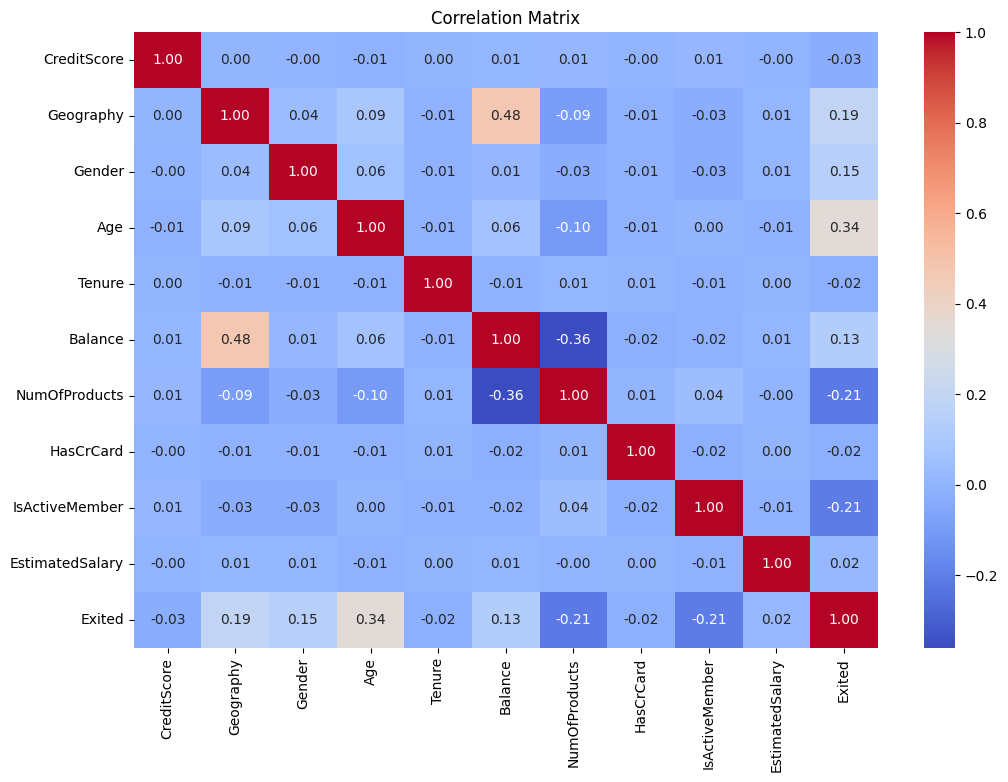

In [10]:


# Encode categoricals temporarily for correlation
train_corr = train.copy()
train_corr['Geography'] = train_corr['Geography'].map({'France': 0, 'Spain': 1, 'Germany': 2})
train_corr['Gender'] = train_corr['Gender'].map({'Male': 0, 'Female': 1})

# Drop the 'Surname' column as it's a string and not relevant for correlation
train_corr = train_corr.drop(columns=['Surname', 'CustomerId', 'id'])

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_corr.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [11]:
# Drop columns with low predictive power
train.drop(['id', 'CustomerId', 'Surname'], axis=1, inplace=True)

# One-hot encoding for Geography and Gender
train = pd.get_dummies(train, columns=['Geography', 'Gender'], drop_first=True)

In [12]:
X = train.drop('Exited', axis=1)
y = train['Exited']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
scaler = StandardScaler()
num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']  # Select numericals
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [16]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("Balanced Train Distribution:\n", y_train_bal.value_counts(normalize=True))

Balanced Train Distribution:
 Exited
0    0.5
1    0.5
Name: proportion, dtype: float64


In [17]:
# Baseline model
base_model = LogisticRegression(random_state=42, max_iter=1000)
base_model.fit(X_train_bal, y_train_bal)

# Predictions
y_pred_base = base_model.predict(X_test)
y_prob_base = base_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Baseline Classification Report:\n", classification_report(y_test, y_pred_base))
print("Baseline ROC-AUC:", roc_auc_score(y_test, y_prob_base))

Baseline Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.76      0.83     26023
           1       0.45      0.73      0.56      6984

    accuracy                           0.75     33007
   macro avg       0.68      0.75      0.69     33007
weighted avg       0.82      0.75      0.77     33007

Baseline ROC-AUC: 0.815540796825295


In [18]:
# Tuned model
model = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10]
}

grid = GridSearchCV(model, param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1)
grid.fit(X_train_bal, y_train_bal)

best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

# Predictions with best model
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

Best Parameters: {'C': 0.01, 'penalty': 'l2'}


Tuned Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.76      0.83     26023
           1       0.45      0.73      0.56      6984

    accuracy                           0.76     33007
   macro avg       0.68      0.75      0.69     33007
weighted avg       0.82      0.76      0.77     33007

Tuned ROC-AUC: 0.8156050958357879


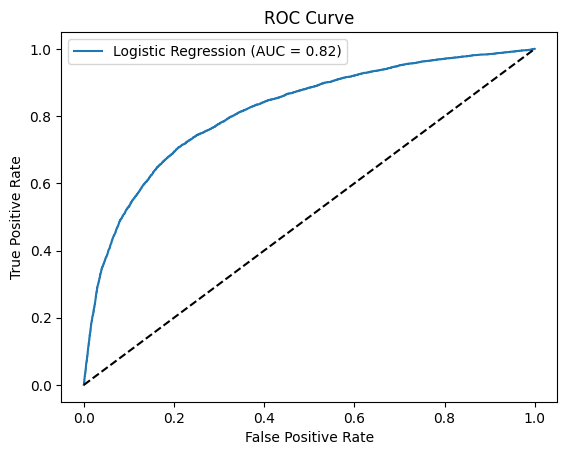

In [19]:
# Classification Report
print("Tuned Classification Report:\n", classification_report(y_test, y_pred))

# ROC-AUC
print("Tuned ROC-AUC:", roc_auc_score(y_test, y_prob))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_score(y_test, y_prob)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

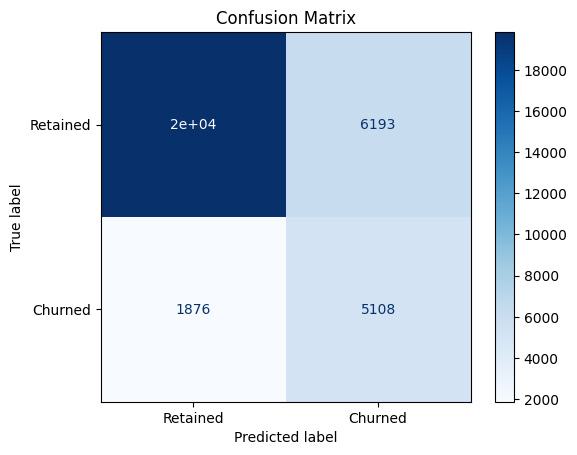

In [20]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Retained', 'Churned'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

              Feature  Coefficient
8   Geography_Germany     1.159375
1                 Age     0.901901
9     Geography_Spain     0.090996
7     EstimatedSalary     0.047696
2              Tenure    -0.045027
3             Balance    -0.062363
0         CreditScore    -0.062844
5           HasCrCard    -0.128750
4       NumOfProducts    -0.405093
10        Gender_Male    -0.616020
6      IsActiveMember    -1.239675


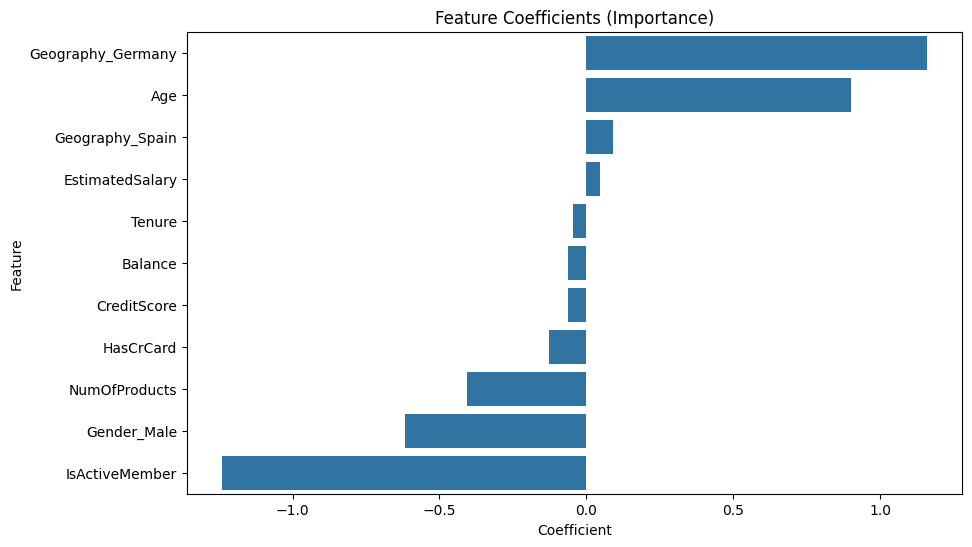

In [21]:
# Coefficients
coefs = pd.DataFrame({'Feature': X.columns, 'Coefficient': best_model.coef_[0]})
coefs = coefs.sort_values('Coefficient', ascending=False)
print(coefs)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefs)
plt.title('Feature Coefficients (Importance)')
plt.show()

In [22]:
joblib.dump(best_model, 'churn_logreg_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [23]:
def predict_churn(new_data):
    # new_data: Dict with keys matching features (e.g., {'CreditScore': 600, 'Geography': 'France', ...})
    df = pd.DataFrame([new_data])
    df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)
    # Align columns to training set (add missing dummies if needed)
    for col in X.columns:
        if col not in df.columns:
            df[col] = 0
    df = df[X.columns]  # Reorder
    df[num_cols] = scaler.transform(df[num_cols])
    prob = best_model.predict_proba(df)[:, 1][0]
    return 'High Risk' if prob > 0.5 else 'Low Risk', prob

# Example usage
sample = {
    'CreditScore': 600, 'Age': 40, 'Tenure': 3, 'Balance': 60000, 'NumOfProducts': 2,
    'HasCrCard': 1, 'IsActiveMember': 1, 'EstimatedSalary': 50000,
    'Geography': 'Germany', 'Gender': 'Female'
}
print(predict_churn(sample))

('Low Risk', np.float64(0.0))


In [24]:
# Load test data
test = pd.read_csv('test.csv')
test_ids = test['id']
test.drop(['id', 'CustomerId', 'Surname'], axis=1, inplace=True)
test = pd.get_dummies(test, columns=['Geography', 'Gender'], drop_first=True)
# Align columns
for col in X.columns:
    if col not in test.columns:
        test[col] = 0
test = test[X.columns]
test[num_cols] = scaler.transform(test[num_cols])

# Predict probabilities
sub_probs = best_model.predict_proba(test)[:, 1]

# Create submission
submission = pd.DataFrame({'id': test_ids, 'Exited': sub_probs})
submission.to_csv('submission.csv', index=False)
print("Submission file created!")

# Download the submission file
files.download('submission.csv')

Submission file created!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>